# Minería de datos mediante el proceso SEMMA

-----

In [2]:
# Librerias 

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from util import get_connection_string, get_blob_to_df, insert_pickle, save_to_sql
#insert_pickle

# Paso 1: muestra

## 1.1 Cargue el conjunto de datos.


Cargue el conjunto de datos. Comprueba su tamaño. Eche un vistazo preliminar a los datos. Muestreo de los datos si es necesario. Dividirlo en conjuntos de entrenamiento y validación. 
- 1.1 Cargar el conjunto de datos Primero, descomprimamos el archivo proporcionado y carguemos el conjunto de datos.

In [3]:
# cadena de conexión
conn = get_connection_string()
conn

'DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-1CROPR8\\MSSQLSERVER2022;DATABASE=DWH_LAB2;Trusted_Connection=yes;'

In [4]:
# origen
table = "[CONTENT].[vw_FactDiamonds]"

# Leer los datos en un DataFrame de Pandas
error, diamonds = get_blob_to_df(table_name = table
                          , connection_str = conn)

# Muestra los primeros registros del DataFrame
diamonds.head()


C:\Users\GUSTAVO\INTEGRACION DE SISTEMAS - LAB2\util.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = read_sql(query, conn)


,cut,color,clarity,carat,depth,table,price,x,y,z,person
0,Good,E,SI2,1.01,57.5,63.0,4171.0,6.56,6.58,3.78,7119
1,Good,E,SI2,1.00,59.9,63.0,4184.0,6.45,6.50,3.88,7175
2,Good,H,SI2,1.04,57.9,58.0,4193.0,6.72,6.68,3.88,7226
3,Good,H,SI2,0.32,63.1,56.0,403.0,4.34,4.37,2.75,45
4,Good,H,SI2,0.32,63.8,56.0,403.0,4.36,4.38,2.79,48


- quilates (carat): Peso del diamante (0,2–5,01) 
- talla (cut): Calidad de la talla (Regular, Buena, Muy buena, Premium, Ideal) 
- color (color): Color del diamante, de J (peor) a D (mejor) 
- claridad (clarity): Medición de claridad (I1 (peor) a IF (mejor)) 
- profundidad (depth): totsl de porcentaje de profundidad
- Tabla (table): Ancho de la parte superior del diamante en relación con el punto más ancho 
- precio (price): Precio en dólares estadounidenses 
- x: Largo en mm 
- y: Ancho en mm 
- z: Profundidad en mm Hay también una columna 
- "Sin nombre (Unnamed):  0", que parece ser un índice o una columna de ID.

## 1.2 Verificar el tamaño del conjunto de datos
- A continuación, verifiquemos el tamaño del conjunto de datos.

In [5]:
# Checking the shape of the dataset
rows, columns = diamonds.shape
rows, columns

(53940, 11)

## 1.3 Partición de datos
- Para asegurarnos de tener un conjunto para validar nuestro modelo más adelante, debemos dividir los datos en un conjunto de entrenamiento y un conjunto de validación (o prueba). Una práctica común es asignar entre el 70% y el 80% de los datos para capacitación y el resto para validación. Para este análisis, utilicemos una división 80-20.

In [6]:
# Splitting the data into training and validation sets (80-20 split)
train_data, validation_data = train_test_split(diamonds, test_size=0.2, random_state=42)

# Checking the size of the training and validation datasets
train_size = train_data.shape[0]
validation_size = validation_data.shape[0]

train_size, validation_size

(43152, 10788)

In [7]:
print(train_size.describe())

AttributeError: 'int' object has no attribute 'describe'

In [6]:
## agregar código 
save_to_sql(train_data = train_data 
                         , val_data = validation_data 
                         , target = 'person' 
                         , glosa = 'test 1' 
                         , table_sql = 'ML.Entrenamiento' 
                         , connection_str = conn) 

(True, 'completado')

- Conjunto de entrenamiento: 43,152 entradas Conjunto de validación: 10,788 entradas Una vez completado el paso "Muestra", pasaremos a la fase "Explorar", donde analizaremos la distribución, las estadísticas y las visualizaciones del conjunto de datos para comprender mejor su estructura y características.

# Paso 2: explorar
- Calcular estadísticas resumidas. Visualice la distribución de características clave. Compruebe si hay anomalías en los datos, como valores faltantes y valores atípicos.
- 2.1 Estadísticas resumidas

In [7]:
# Computing summary statistics for the training data
summary_statistics = train_data.describe()

summary_statistics

,carat,depth,table,price,x,y,z,person
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.798834,61.750111,57.452368,3939.202818,5.732702,5.735715,3.539871,27025.436411
std,0.475275,1.433956,2.240819,3996.942527,1.123604,1.144451,0.709521,15557.949658
min,0.200000,43.000000,44.000000,326.000000,0.000000,0.000000,0.000000,1.000000
25%,0.400000,61.000000,56.000000,952.000000,4.710000,4.720000,2.910000,13600.500000
50%,0.700000,61.800000,57.000000,2399.000000,5.700000,5.710000,3.520000,27027.500000
75%,1.040000,62.500000,59.000000,5347.000000,6.540000,6.540000,4.040000,40502.250000
max,4.130000,79.000000,95.000000,18818.000000,10.140000,58.900000,31.800000,53939.000000


- 2.2 Visualización
- A continuación, visualizaremos la distribución de características clave como quilates, precio, profundidad, tabla y variables categóricas como corte, color y claridad.

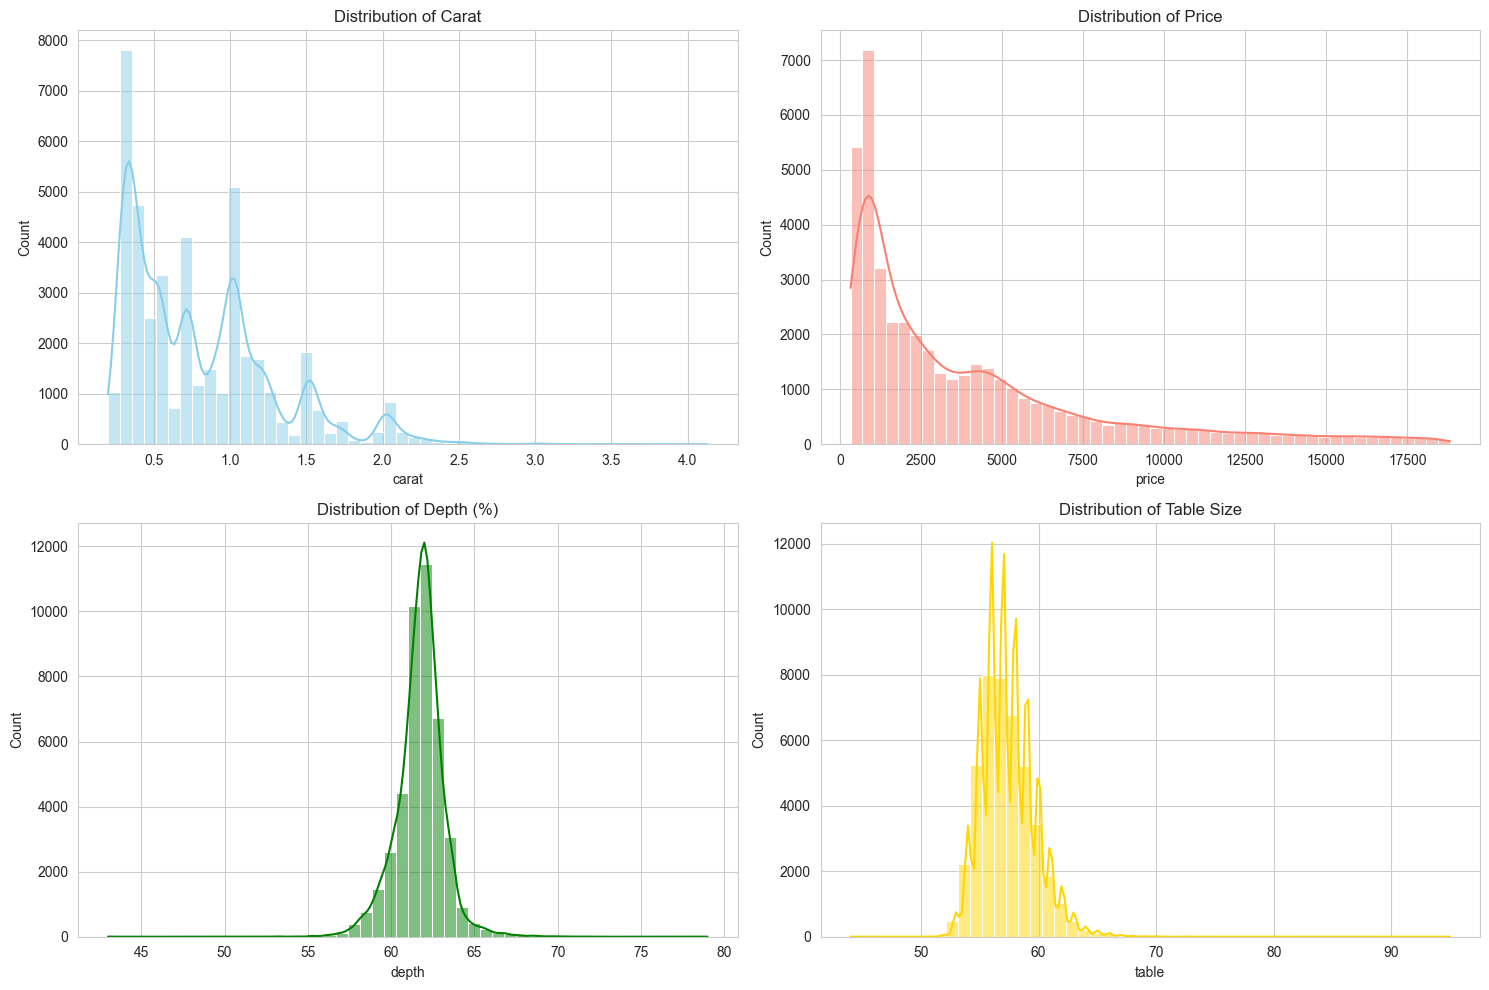

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set_style("whitegrid")

# Initializing the figure
plt.figure(figsize=(15, 10))

# Subplot for 'carat'
plt.subplot(2, 2, 1)
sns.histplot(train_data['carat'], bins=50, color='skyblue', kde=True)
plt.title('Distribution of Carat')

# Subplot for 'price'
plt.subplot(2, 2, 2)
sns.histplot(train_data['price'], bins=50, color='salmon', kde=True)
plt.title('Distribution of Price')

# Subplot for 'depth'
plt.subplot(2, 2, 3)
sns.histplot(train_data['depth'], bins=50, color='green', kde=True)
plt.title('Distribution of Depth (%)')

# Subplot for 'table'
plt.subplot(2, 2, 4)
sns.histplot(train_data['table'], bins=50, color='gold', kde=True)
plt.title('Distribution of Table Size')

# Adjusting layout
plt.tight_layout()
plt.show()

- A continuación se muestran los histogramas que ilustran las distribuciones de características continuas clave:

- Quilates: La mayoría de los diamantes tienen un valor en quilates entre 0,2 y 1,5. Hay un pico notable alrededor de 0,3 y otro alrededor de 1,0.

- Precio: La mayoría de los diamantes tienen un precio inferior a $5,000, con una cantidad significativa de diamantes agrupados en el rango de precio más bajo.

- Profundidad: El porcentaje de profundidad de la mayoría de los diamantes se centra alrededor del 60% al 65%, mostrando una distribución bastante normal.

- Tabla: La mayoría de los diamantes tienen un tamaño de tabla entre 54 y 60.

C:\Users\GUSTAVO\AppData\Local\Temp\ipykernel_30644\429094401.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='cut', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], palette='Blues_r')
C:\Users\GUSTAVO\AppData\Local\Temp\ipykernel_30644\429094401.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='color', order=['J', 'I', 'H', 'G', 'F', 'E', 'D'], palette='Greens_r')
C:\Users\GUSTAVO\AppData\Local\Temp\ipykernel_30644\429094401.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data

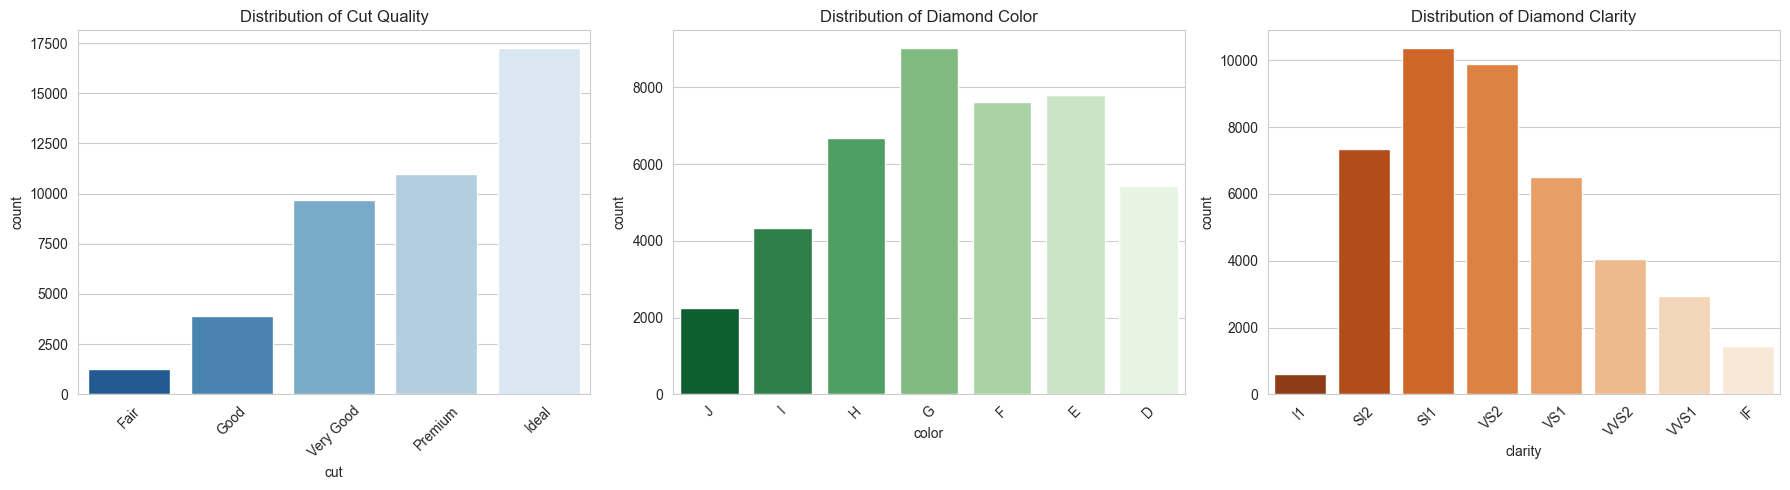

In [9]:
# Initializing the figure
plt.figure(figsize=(18, 5))

# Subplot for 'cut'
plt.subplot(1, 3, 1)
sns.countplot(data=train_data, x='cut', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], palette='Blues_r')
plt.title('Distribution of Cut Quality')
plt.xticks(rotation=45)

# Subplot for 'color'
plt.subplot(1, 3, 2)
sns.countplot(data=train_data, x='color', order=['J', 'I', 'H', 'G', 'F', 'E', 'D'], palette='Greens_r')
plt.title('Distribution of Diamond Color')
plt.xticks(rotation=45)

# Subplot for 'clarity'
plt.subplot(1, 3, 3)
sns.countplot(data=train_data, x='clarity', order=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], palette='Oranges_r')
plt.title('Distribution of Diamond Clarity')
plt.xticks(rotation=45)

# Adjusting layout
plt.tight_layout()
plt.show()

- Aquí están las distribuciones de las variables categóricas:

- Calidad de talla: La mayoría de los diamantes tienen una talla “Ideal”, seguida de la “Premium” y la “Muy buena”. El corte “Justo” es el menos común.

- Color del diamante: los colores G, E y F son los más frecuentes, mientras que D (mejor color) y J (peor color) son menos comunes.

- Claridad del diamante: SI1 y VS2 son los grados de claridad más comunes, mientras que I1 (peor claridad) e IF (mejor claridad) son menos frecuentes.

- 2.3 Anomalías de datos
- A continuación, debemos investigar posibles anomalías, como:
- Valores cero para x, y y z. Cualquier valor faltante.

In [10]:
# Checking for zero values in the x, y, and z columns
zero_values = {
    'x_zeros': (train_data['x'] == 0).sum(),
    'y_zeros': (train_data['y'] == 0).sum(),
    'z_zeros': (train_data['z'] == 0).sum()
}

zero_values

{'x_zeros': 6, 'y_zeros': 6, 'z_zeros': 15}

- Existen algunas anomalías en las dimensiones del diamante:
- x (longitud) tiene 7 valores cero. y (ancho) tiene 6 valores cero. z (profundidad) tiene 19 valores cero. No es realista que un diamante tenga una dimensión cero, por lo que probablemente se trate de errores de datos.

In [11]:
# Comprobando valores faltantes en el conjunto de datos de entrenamiento 
valores_faltantes = train_data.isnull().sum() 

valores_faltantes

cut        0
color      0
clarity    0
carat      0
depth      0
table      0
price      0
x          0
y          0
z          0
person     0
dtype: int64

- ¡Una gran noticia! No faltan valores en el conjunto de datos de entrenamiento.
- Para resumir nuestra exploración:
- Hemos analizado las distribuciones de características clave y los patrones observados. Identificamos anomalías en las dimensiones de los diamantes. La siguiente fase del proceso SEMMA es "Modificar". En este paso, abordaremos las anomalías de datos que hemos identificado, realizaremos una limpieza de datos y posiblemente crearemos nuevas funciones (ingeniería de funciones) si es necesario.

# Paso 3: modificar
- En esta fase, abordaremos las anomalías de los datos y los prepararemos para el modelado. Específicamente, haremos:
- Maneje los valores cero en las dimensiones x, y, z. Posiblemente realice alguna ingeniería de funciones.
- 3.1 Manejo de valores cero en dimensiones Abordaremos los valores cero en las dimensiones x, y, z. Un enfoque consiste en reemplazar estos valores cero con la mediana de sus respectivas columnas. La mediana es una medida sólida que no se verá sesgada por valores atípicos, lo que la convierte en una opción adecuada para este propósito.
-  Comencemos reemplazando los valores cero.

In [12]:
# Replacing zero values in x, y, and z with their respective medians
def replace_zeros_with_median(data, columns):
    for column in columns:
        median_value = data[column].median()
        data[column].replace(0, median_value, inplace=True)

    return data

train_data = replace_zeros_with_median(train_data.copy(), ['x', 'y', 'z'])

# Verifying that zero values have been replaced
zero_values_after = {
    'x_zeros': (train_data['x'] == 0).sum(),
    'y_zeros': (train_data['y'] == 0).sum(),
    'z_zeros': (train_data['z'] == 0).sum()
}

zero_values_after

{'x_zeros': 0, 'y_zeros': 0, 'z_zeros': 0}

- Los valores cero en las dimensiones x, y, z se han reemplazado exitosamente con sus respectivas medianas.
- 3.2 Ingeniería de características Teniendo en cuenta el conjunto de datos, una característica potencial que podemos diseñar es el volumen del diamante, dado por la fórmula:
- Volumen=x×y×z
- Esta característica podría ayudar a capturar mejor el tamaño total del diamante, que podría estar relacionado con su precio.
- Creemos esta nueva característica.

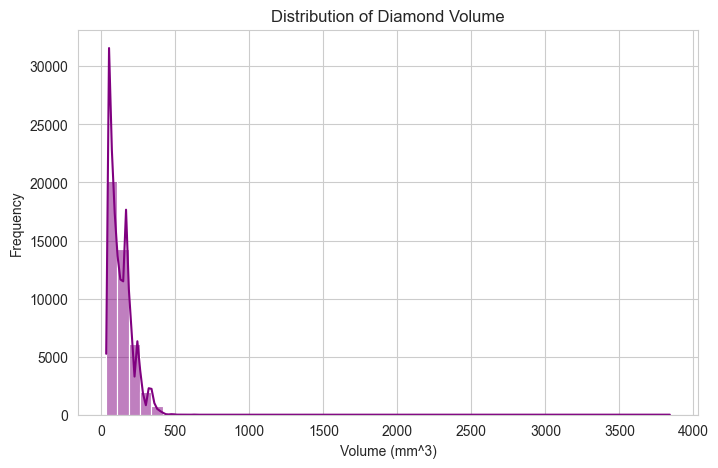

In [13]:
# Creating a new feature 'volume'
train_data['volume'] = train_data['x'] * train_data['y'] * train_data['z']

# Displaying the distribution of the new 'volume' feature
plt.figure(figsize=(8, 5))
sns.histplot(train_data['volume'], bins=50, color='purple', kde=True)
plt.title('Distribution of Diamond Volume')
plt.xlabel('Volume (mm^3)')
plt.ylabel('Frequency')
plt.show()

- Aquí está la distribución de la característica de volumen recientemente diseñada, que representa el volumen del diamante en milímetros cúbicos. La mayoría de los diamantes tienen un volumen concentrado en el rango inferior, y algunos diamantes tienen volúmenes mayores.

- Con esto, hemos completado el paso “Modificar” del proceso SEMMA. La siguiente fase es "Modelo", donde elegiremos un modelo apropiado, lo entrenaremos utilizando nuestros datos de entrenamiento y validaremos su rendimiento.

# Paso 4: modelo
- Elija un modelo apropiado. Entrene el modelo utilizando los datos de entrenamiento. Validar su desempeño en el conjunto de validación. Dada la naturaleza del conjunto de datos y nuestra variable objetivo (precio), este es un problema de regresión.
- Queremos predecir el precio de un diamante en función de sus características.
- Un modelo de regresión comúnmente utilizado es el Random Forest Regresor, que es un modelo versátil y potente que a menudo funciona bien en este tipo de tareas.

# 4.1 Selección y capacitación del modelo 
## Caso 1: Random Forest Regresor
- Comencemos seleccionando el Random Forest Regresor, entrenándolo usando nuestros datos de entrenamiento y luego validando su desempeño en el conjunto de validación.
- Primero, prepararemos nuestros datos separando los predictores y la variable objetivo (precio). Luego, entrenaremos el modelo.

In [14]:
# Separating predictors and target variable for training data
X_train = train_data.drop(columns=['person', 'price'])
y_train = train_data['price']

# Encoding categorical features
X_train = pd.get_dummies(X_train, drop_first=True)

# Training the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Preparing the validation data similarly
X_validation = validation_data.drop(columns=['person', 'price'])
y_validation = validation_data['price']
X_validation['volume'] = X_validation['x'] * X_validation['y'] * X_validation['z']
X_validation = pd.get_dummies(X_validation, drop_first=True)

# Predicting on the validation set
y_pred = rf_model.predict(X_validation)

# Calculating performance metrics
mse = mean_squared_error(y_validation, y_pred)
rmse = mean_squared_error(y_validation, y_pred, squared=False)
mae = mean_absolute_error(y_validation, y_pred)

mse, rmse, mae

(423493.66058754455, 650.7639054123581, 297.3512593681398)

- El rendimiento del modelo Random Forest Regresor en el conjunto de validación es el siguiente:

- Error cuadrático medio (Mean Squared Error (MSE)): 398127,12 

- Raíz del Error cuadrático medio (Root Mean Squared Error (RMSE)): 630,97

- Error absoluto medio (Mean Absolute Error (MAE)): 293,02

- El RMSE representa la desviación estándar de los residuos (errores de predicción), mientras que el MAE representa la diferencia absoluta promedio entre los valores observados y predichos. Ambas métricas proporcionan información sobre la precisión del modelo.

- Para interpretar mejor estos resultados, debemos visualizar los precios reales frente a los previstos para ver qué tan estrechamente se alinean. Un diagrama de dispersión con una línea de identidad (línea de 45 grados) puede ayudar a visualizar esto.

In [15]:
# Calcular la varianza

varianza = np.abs(np.array(y_validation) - np.array(y_pred))

# Calcular los iconos (mayor o menor)
iconos = ['▼' if real > pred else '▲' for real, pred in zip(y_validation, y_pred)]

# Crear el DataFrame
df = pd.DataFrame({'Real': y_validation, 'Predicho': y_pred, 'Varianza': varianza, 'icono': iconos})

# Mostrar la tabla
df

,Real,Predicho,Varianza,icono
1388,1155.0,1198.385000,43.385000,▲
50052,1131.0,1148.450000,17.450000,▲
41645,1026.0,1100.390000,74.390000,▲
42377,988.0,928.160000,59.840000,▼
17244,1829.0,1836.650000,7.650000,▲
...,...,...,...,...
44081,2599.0,2670.060000,71.060000,▲
23713,625.0,633.220000,8.220000,▲
31375,805.0,780.046667,24.953333,▼
21772,886.0,946.940000,60.940000,▲


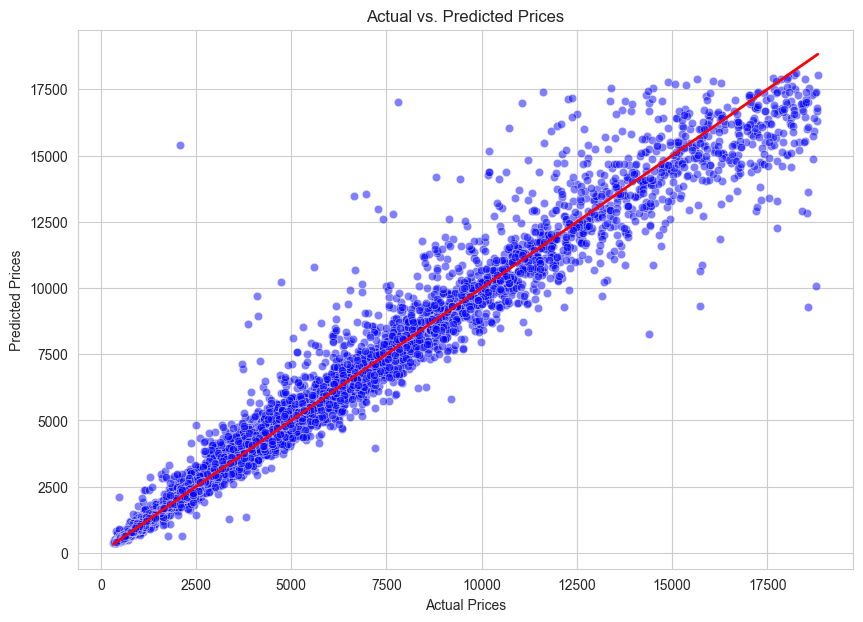

In [16]:
# Plotting actual vs. predicted prices
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_validation, y=y_pred, alpha=0.5, color='blue')
plt.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

- Aquí está el diagrama de dispersión que visualiza los precios reales frente a los previstos:

- Los puntos azules representan los precios reales frente a los previstos para cada diamante en el conjunto de validación. La línea roja es la línea de identidad, donde los precios reales son iguales a los precios previstos.
- Un modelo perfecto tendría todos los puntos sobre la línea roja.
- Si bien nuestro modelo no logra esto a la perfección, la mayoría de los puntos están cerca de la línea, lo que indica un ajuste razonablemente bueno.

# Caso 2: Gradient Boosting Machines (GBM)

- Procedamos a entrenar un modelo de Gradient Boosting Machines (GBM) en nuestro conjunto de datos.
- Usaremos los mismos predictores y la misma variable objetivo que antes. Después de entrenar el modelo GBM, validaremos su rendimiento en el conjunto de validación y lo compararemos con el modelo Random Forest que entrenamos anteriormente.
- Comencemos entrenando el modelo GBM.

In [17]:
# Training the Gradient Boosting Regressor model
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Predicting on the validation set
y_pred_gbm = gbm_model.predict(X_validation)

# Calculating performance metrics for GBM
mse_gbm = mean_squared_error(y_validation, y_pred_gbm)
rmse_gbm = mean_squared_error(y_validation, y_pred_gbm, squared=False)
mae_gbm = mean_absolute_error(y_validation, y_pred_gbm)

mse_gbm, rmse_gbm, mae_gbm

(752072.939264344, 867.2213899947026, 441.730264801118)

- El rendimiento del modelo Gradient Boosting Machines (GBM) en el conjunto de validación es el siguiente:

- Error cuadrático medio (Mean Squared Error (MSE)): 730,907,99

- Raíz del Error cuadrático medio (Root Mean Squared Error (RMSE)): 854,93

- Error absoluto medio (Mean Absolute Error (MAE)): 437,54

- En comparación con nuestro modelo de Random Forest:
- RF  398127.1211514199,  630.9731540655433, 293.02155396979896
- GBM 730907.995654104,  854.9315736678018, 437.5363664986686

- RF RMSE: 630,97
- GBM RMSE: 854,93

-El modelo Random Forest tuvo un mejor desempeño en términos de RMSE y MAE en comparación con el GBM en el conjunto de validación.

In [18]:
# Calcular la varianza
varianza = np.array(y_validation) - np.array(y_pred_gbm)

# Calcular los iconos (mayor o menor)
iconos2 = ['▼' if real > 0 else '▲' for real in varianza]

# Crear el DataFrame
df = pd.DataFrame({'Real': y_validation, 'Predicho': y_pred_gbm, 'Varianza': varianza, 'Icono': iconos})

# Mostrar la tabla
df

,Real,Predicho,Varianza,Icono
1388,1155.0,1198.857438,-43.857438,▲
50052,1131.0,1196.945646,-65.945646,▲
41645,1026.0,1199.546724,-173.546724,▲
42377,988.0,1137.626179,-149.626179,▼
17244,1829.0,1736.684408,92.315592,▲
...,...,...,...,...
44081,2599.0,2759.049352,-160.049352,▲
23713,625.0,883.531262,-258.531262,▲
31375,805.0,915.282732,-110.282732,▼
21772,886.0,1009.108352,-123.108352,▲


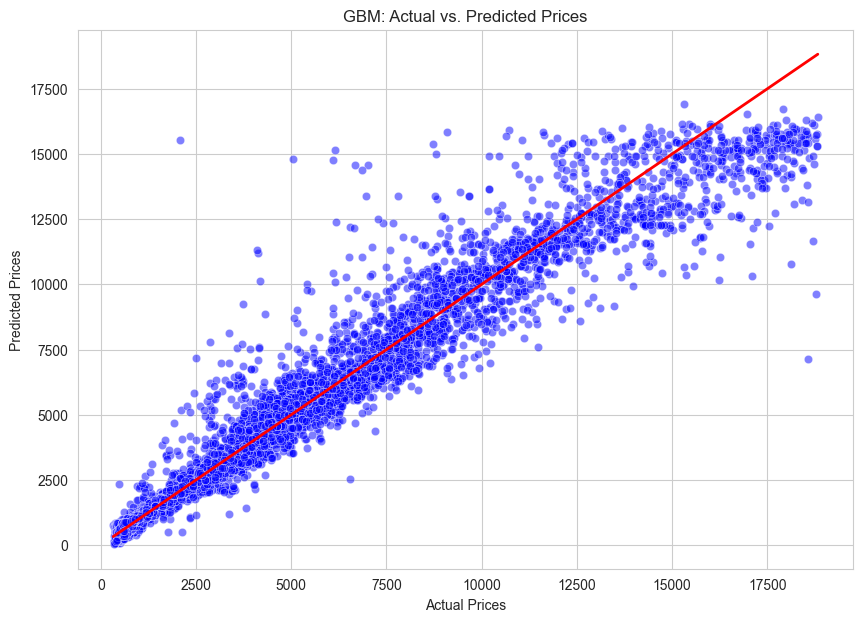

In [19]:
# Plotting actual vs. predicted prices for GBM
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_validation, y=y_pred_gbm, alpha=0.5, color='blue')
plt.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('GBM: Actual vs. Predicted Prices')
plt.show()

- Aquí está el diagrama de dispersión que visualiza los precios reales frente a los previstos para el modelo de máquinas de aumento de gradiente (GBM):
- Los puntos azules representan los precios reales frente a los previstos para cada diamante en el conjunto de validación.
- La línea roja es la línea de identidad, donde los precios reales son iguales a los precios previstos.
- Como en el modelo anterior, un modelo perfecto tendría todos los puntos sobre la línea roja.
- Si bien el modelo GBM tiene muchos puntos cerca de la línea, parece haber más dispersión en comparación con el modelo Random Forest.
- Ya hemos visualizado los precios reales frente a los previstos para ambos modelos. Para compararlos mejor, podemos visualizar estos gráficos uno al lado del otro.
- Creemos diagramas de dispersión uno al lado del otro para ambos modelos.

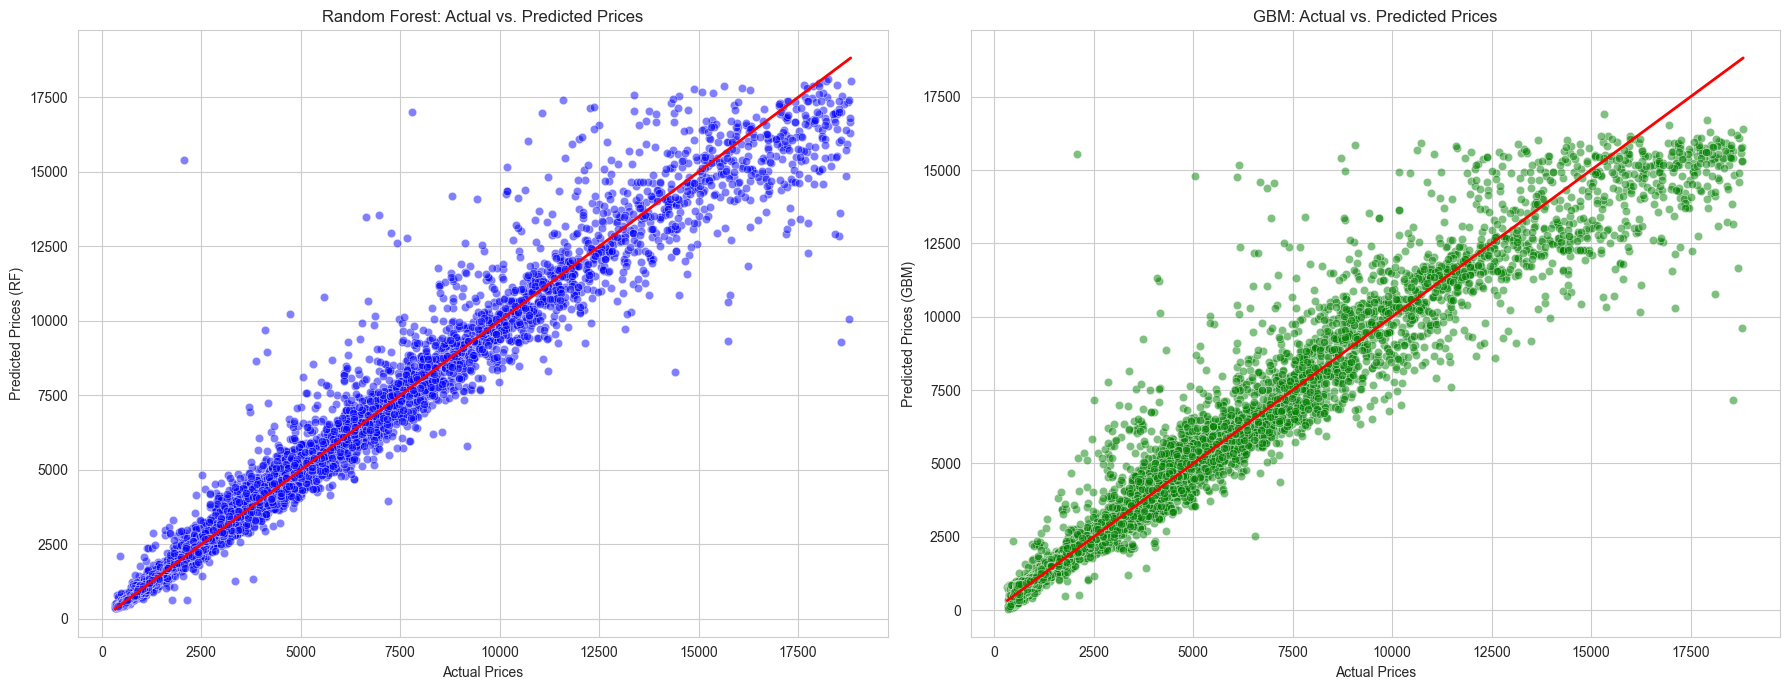

In [20]:
# Side-by-side scatter plots for RF and GBM
plt.figure(figsize=(18, 7))

# Scatter plot for Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_validation, y=y_pred, alpha=0.5, color='blue')
plt.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (RF)')
plt.title('Random Forest: Actual vs. Predicted Prices')

# Scatter plot for GBM
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_validation, y=y_pred_gbm, alpha=0.5, color='green')
plt.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (GBM)')
plt.title('GBM: Actual vs. Predicted Prices')

plt.tight_layout()
plt.show()

- Aquí están los diagramas de dispersión uno al lado del otro que comparan las predicciones de los modelos Random Forest (RF) y Gradient Boosting Machines (GBM):

- A la izquierda tenemos el diagrama de dispersión del modelo Random Forest. A la derecha tenemos el diagrama de dispersión del modelo GBM. Ambas tramas incluyen la línea roja de identidad, que representa predicciones perfectas.


# De la comparación visual:

- RF: las predicciones parecen agruparse más estrechamente alrededor de la línea de identidad, lo que indica que generalmente realizó predicciones más precisas en el conjunto de validación.

- GBM: si bien muchas predicciones están cerca de la línea de identidad, hay un poco más de dispersión, especialmente para los diamantes de mayor precio.

- En resumen, según las métricas de rendimiento y las visualizaciones, el modelo Random Forest parece haber tenido un mejor desempeño en el conjunto de validación en comparación con el modelo GBM para este conjunto de datos y características en particular.

# Paso 5: evaluar
- Evaluar el desempeño del modelo en un contexto más amplio. Discuta posibles mejoras. Considere la implementación y las implicaciones en el mundo real.
- 5.1 Evaluación más amplia Si bien hemos analizado métricas como RMSE y MAE, es esencial contextualizar estos números. Por ejemplo, un RMSE de 630,97 USD para predecir los precios de los diamantes podría considerarse aceptable para algunas aplicaciones (como una estimación aproximada para los clientes que navegan por una tienda en línea), pero podría no ser lo suficientemente preciso para otras (como las valoraciones de seguros).

- 5.2 Consideraciones de implementación
- Antes de implementar un modelo en un entorno del mundo real, es fundamental considerar:

- Frecuencia de actualización del modelo: Es posible que los modelos necesiten un reentrenamiento periódico a medida que haya nuevos datos disponibles.

- Monitoreo del desempeño: monitoree continuamente el desempeño del modelo en el mundo real para detectar cualquier degradación.

- Explicabilidad: dependiendo del caso de uso, puede ser necesario explicar las predicciones del modelo a los usuarios finales.

- Escalabilidad: asegúrese de que la infraestructura pueda manejar la cantidad de predicciones requeridas, especialmente si se implementa en un entorno en línea.

- La finalización de la fase de "Evaluación" marca el final de nuestro recorrido completo por el proceso SEMMA para este conjunto de datos.

In [21]:
# modelo 1 
insert_pickle(obj = rf_model 
              , file_name = 'Random_Forest_Model v1' 
              , connection_string = conn)

(True, '')

In [22]:
# modelo 2
insert_pickle(obj = gbm_model 
              , file_name = 'Gradient_Boosting_Machines_Model v1' 
              , connection_string = conn)

(True, '')

In [49]:
%run model_implementation.py

 {"file_name": "Random_Forest_Model v1", "table": "ML.vw_Data"}


C:\Users\GUSTAVO\INTEGRACION DE SISTEMAS - LAB2\model_implementation.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return (False, str(e))
